# Treinamento e Avaliação - Dataset COCO Final - Classe Gun (COM AUGMENTATIONS)

Este notebook treina e avalia um modelo EfficientDet usando o dataset COCO final **com augmentations avançadas**.

**Dataset:** `dataset_final_coco`
**Classe:** Gun (apenas uma classe)
**Modelo:** EfficientDet-D1
**Treinamento:** (1500 imagens)
**Avaliação:** Subset do dataset de teste
**Augmentations:** Aplicadas conforme parâmetros especificados (ver célula de configuração)

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import json
import time
from datetime import datetime, timedelta
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Importações do EfficientDet
from effdet import get_efficientdet_config, create_model, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.bench import DetBenchPredict

print("✅ Bibliotecas importadas com sucesso!")
print("📦 EfficientDet será baixado automaticamente quando você carregar o modelo pré-treinado.")

✅ Bibliotecas importadas com sucesso!
📦 EfficientDet será baixado automaticamente quando você carregar o modelo pré-treinado.


In [2]:
# ================================================================
# CONFIGURAÇÃO DE GERENCIAMENTO DE MEMÓRIA CUDA
# ================================================================

import gc
import os

gc.collect()

# Limpar cache CUDA no início
if torch.cuda.is_available():
    # Apenas a limpeza do cache é universalmente suportada.
    torch.cuda.empty_cache()
    
    # Verificação de memória compatível com PyTorch 1.x
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3

    print(f"✅ Cache CUDA limpo. Memória total da GPU: {total_memory:.2f} GB")
    print(f"Nome da GPU: {torch.cuda.get_device_name(0)}")

# Se a verificação for True e o nome da GPU for exibido, o ambiente está pronto para uso.


✅ Cache CUDA limpo. Memória total da GPU: 6.00 GB
Nome da GPU: NVIDIA GeForce GTX 1060 6GB


In [3]:
class CocoAlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_file, transforms=None, subset_size=None):
        self.img_dir = img_dir
        self.transforms = transforms

        with open(ann_file, "r") as f:
            data = json.load(f)

        self.images = {img["id"]: img for img in data["images"]}

        # Agrupar anotações por imagem
        self.annotations = {}
        for ann in data["annotations"]:
            img_id = ann["image_id"]
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)

        self.ids = list(self.images.keys())
        
        # Limitar a um subset se especificado
        if subset_size is not None and subset_size < len(self.ids):
            self.ids = self.ids[:subset_size]
            print(f"📊 Usando subset de {len(self.ids)} imagens (de {len(self.images)} total)")
        
        # Verificação de anotações
        total_images = len(self.ids)
        images_with_anns = sum(1 for img_id in self.ids if img_id in self.annotations and len(self.annotations[img_id]) > 0)
        total_anns = sum(len(self.annotations.get(img_id, [])) for img_id in self.ids)
        
        print(f"✅ Dataset carregado:")
        print(f"   📊 Imagens no subset: {total_images}")
        print(f"   📊 Imagens com anotações: {images_with_anns}")
        print(f"   📊 Total de anotações: {total_anns}")

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.images[img_id]

        img_path = os.path.join(self.img_dir, info["file_name"])
        image = np.array(Image.open(img_path).convert("RGB"))

        annots = self.annotations.get(img_id, [])

        # Se não tem boxes, retorna None
        if len(annots) == 0:
            return None

        boxes = []
        labels = []

        for ann in annots:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            # EfficientDet aceita category_id diretamente (1 para gun)
            labels.append(ann["category_id"])

        if self.transforms:
            transformed = self.transforms(
                image=image,
                bboxes=boxes,
                labels=labels
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            labels = transformed["labels"]

        if len(boxes) == 0:
            return None

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id], dtype=torch.int64)
        }

        return image, target

    def __len__(self):
        return len(self.ids)

In [4]:
# ================================================================
# REDUZIR BATCH SIZE PARA EVITAR OOM
# ================================================================
BATCH_SIZE = 4
print(f"📦 Batch size ajustado para: {BATCH_SIZE} (para evitar OOM)")


📦 Batch size ajustado para: 4 (para evitar OOM)


In [5]:
# 🚨 DEFINIÇÃO DO MODEL_SIZE 🚨
MODEL_SIZE = 640 # Tamanho de entrada do EfficientDet-D1

# Configurações
root_dir = "dataset_final_coco"
device = torch.device("cuda")
print(f"💻 Device: {device}")

# Definir subset size (avaliar apenas uma parte do dataset)
SUBSET_SIZE = 3000 
print(f"\n📊 Configuração:")
print(f"   📂 Dataset: {root_dir}")
print(f"   📸 Tamanho de Entrada: {MODEL_SIZE}x{MODEL_SIZE}")
print(f"   📸 Subset size: {SUBSET_SIZE} imagens")

val_transforms = A.Compose([
    A.Resize(height=MODEL_SIZE, width=MODEL_SIZE, p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Carregar dataset de VALIDAÇÃO (usado durante treinamento)
val_dataset = CocoAlbumentationsDataset(
    img_dir=os.path.join(root_dir, "val", "images"),
    ann_file=os.path.join(root_dir, "coco_annotations_val.json"),
    transforms=val_transforms,
    subset_size=SUBSET_SIZE
)

# Filtrar None values
valid_indices = [i for i in range(len(val_dataset)) if val_dataset[i] is not None]

# 🚨 CRIAÇÃO DO SUBSET FINAL (Robustez) 🚨
# Este é o dataset que deve ser usado no DataLoader ou na avaliação.
final_val_dataset = Subset(val_dataset, valid_indices)

print(f"\n✅ Dataset de VALIDAÇÃO final preparado: {len(final_val_dataset)} imagens válidas")

💻 Device: cuda

📊 Configuração:
   📂 Dataset: dataset_final_coco
   📸 Tamanho de Entrada: 640x640
   📸 Subset size: 3000 imagens
📊 Usando subset de 3000 imagens (de 4287 total)
✅ Dataset carregado:
   📊 Imagens no subset: 3000
   📊 Imagens com anotações: 3000
   📊 Total de anotações: 4543

✅ Dataset de VALIDAÇÃO final preparado: 3000 imagens válidas


In [6]:
# 🚨 DEFINIÇÃO DO MODEL_SIZE 🚨
MODEL_SIZE = 640 # Tamanho de entrada do EfficientDet-D1

# Configurações
root_dir = "dataset_final_coco"
device = torch.device("cuda")
print(f"💻 Device: {device}")

# Definir subset size (avaliar apenas uma parte do dataset)
SUBSET_SIZE = 100 
print(f"\n📊 Configuração:")
print(f"   📂 Dataset: {root_dir}")
print(f"   📸 Tamanho de Entrada: {MODEL_SIZE}x{MODEL_SIZE}")
print(f"   📸 Subset size: {SUBSET_SIZE} imagens")

val_transforms = A.Compose([
    A.Resize(height=MODEL_SIZE, width=MODEL_SIZE, p=1.0), 
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Carregar dataset de VALIDAÇÃO (usado durante treinamento)
val_dataset = CocoAlbumentationsDataset(
    img_dir=os.path.join(root_dir, "val", "images"),
    ann_file=os.path.join(root_dir, "coco_annotations_val.json"),
    transforms=val_transforms,
    subset_size=SUBSET_SIZE
)

# Cria a lista de índices que não retornam None
valid_indices = [i for i in range(len(val_dataset)) if val_dataset[i] is not None]

# Cria um Subset PyTorch contendo apenas os dados válidos
final_val_dataset = Subset(val_dataset, valid_indices)

print(f"\n✅ Dataset de VALIDAÇÃO final preparado: {len(final_val_dataset)} imagens válidas")

💻 Device: cuda

📊 Configuração:
   📂 Dataset: dataset_final_coco
   📸 Tamanho de Entrada: 640x640
   📸 Subset size: 100 imagens
📊 Usando subset de 100 imagens (de 4287 total)
✅ Dataset carregado:
   📊 Imagens no subset: 100
   📊 Imagens com anotações: 100
   📊 Total de anotações: 129

✅ Dataset de VALIDAÇÃO final preparado: 100 imagens válidas


In [7]:
# 🚨 DEFINIÇÃO DO MODEL_SIZE 🚨
MODEL_SIZE = 640 # Tamanho de entrada do EfficientDet-D1

# Configurações
root_dir = "dataset_final_coco"
device = torch.device("cuda")
print(f"💻 Device: {device}")

# Definir subset size (avaliar apenas uma parte do dataset)
SUBSET_SIZE = 100 
print(f"\n📊 Configuração:")
print(f"   📂 Dataset: {root_dir}")
print(f"   📸 Tamanho de Entrada: {MODEL_SIZE}x{MODEL_SIZE}")
print(f"   📸 Subset size: {SUBSET_SIZE} imagens")

# 🚨 CORREÇÃO 1: Adicionar A.Resize às transformações 🚨
val_transforms = A.Compose([
    A.Resize(height=MODEL_SIZE, width=MODEL_SIZE, p=1.0), 
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Carregar dataset de TESTE
test_dataset = CocoAlbumentationsDataset(
    img_dir=os.path.join(root_dir, "test", "images"),
    ann_file=os.path.join(root_dir, "coco_annotations_test.json"),
    transforms=val_transforms,
    subset_size=SUBSET_SIZE
)

# Cria a lista de índices que não retornam None
valid_indices = [i for i in range(len(test_dataset)) if test_dataset[i] is not None]

final_test_dataset = Subset(test_dataset, valid_indices)

print(f"\n✅ Dataset de TESTE final preparado: {len(final_test_dataset)} imagens válidas")

💻 Device: cuda

📊 Configuração:
   📂 Dataset: dataset_final_coco
   📸 Tamanho de Entrada: 640x640
   📸 Subset size: 100 imagens
📊 Usando subset de 100 imagens (de 2145 total)
✅ Dataset carregado:
   📊 Imagens no subset: 100
   📊 Imagens com anotações: 100
   📊 Total de anotações: 120

✅ Dataset de TESTE final preparado: 100 imagens válidas


In [8]:
# ================================================================
# CONFIGURAÇÃO DO MODELO EFFICIENTDET
# ================================================================

print("📦 Carregando modelo EfficientDet-D1...")
print("   ⏳ Os pesos pré-treinados serão baixados automaticamente na primeira execução.")
print("   📥 Isso pode levar alguns minutos na primeira vez...\n")

num_classes = 1  # Apenas Gun (sem background)

# Config do modelo EfficientDet-D1 (640x640)
config = get_efficientdet_config('tf_efficientdet_d1')

config.num_classes = num_classes
config.image_size = (640, 640)
config.norm_kwargs = dict(eps=1e-4)

# Carregar modelo pré-treinado (baixa automaticamente os pesos)
# pretrained_backbone=True faz o download automático dos pesos do backbone
model = EfficientDet(config, pretrained_backbone=True)

# Substituir head para o número correto de classes
model.class_net = HeadNet(config, num_outputs=config.num_classes)

# Wrap para treinamento correto
model = DetBenchTrain(model, config)

# Mover para device
model = model.to(device)

print(f"\n✅ Modelo EfficientDet-D1 configurado com sucesso!")
print(f"   📊 Classes: {num_classes} (Gun)")
print(f"   📐 Tamanho da imagem: {config.image_size}")
print(f"   💻 Device: {device}")
print(f"   📦 Pesos pré-treinados carregados automaticamente!")

📦 Carregando modelo EfficientDet-D1...
   ⏳ Os pesos pré-treinados serão baixados automaticamente na primeira execução.
   📥 Isso pode levar alguns minutos na primeira vez...



Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.



✅ Modelo EfficientDet-D1 configurado com sucesso!
   📊 Classes: 1 (Gun)
   📐 Tamanho da imagem: [640, 640]
   💻 Device: cuda
   📦 Pesos pré-treinados carregados automaticamente!


In [9]:
# 🚨 DEFINIÇÃO DO MODEL_SIZE 🚨
MODEL_SIZE = 640 # Tamanho de entrada do EfficientDet-D1

# ================================================================
# CONFIGURAÇÃO DO DATASET DE TREINO COM AUGMENTATIONS AVANÇADAS
# ================================================================

# Parâmetros de augmentation (conforme especificado no Faster R-CNN)
AUGMENT_CONFIG = {
    'hsv_h': 0.015,      # HSV hue augmentation (fraction)
    'hsv_s': 0.7,        # HSV saturation augmentation (fraction)
    'hsv_v': 0.4,        # HSV value augmentation (fraction)
    'degrees': 0.0,       # Image rotation (degrees) - DESABILITADO
    'translate': 0.1,    # Image translation (fraction)
    'scale': 0.5,        # Image scale (linear)
    'shear': 0.0,        # Image shear (degrees) - DESABILITADO
    'perspective': 0.0,  # Image perspective - DESABILITADO
    'flipud': 0.0,       # Flip image upside down (probability) - DESABILITADO
    'fliplr': 0.5,       # Flip image left-right (probability)
    'mosaic': 1.0,       # Mosaic augmentation (probability) - será implementado customizado
    'mixup': 0.0,        # Mixup augmentation (probability) - DESABILITADO
    'copy_paste': 0.0,   # Copy-paste augmentation (probability) - DESABILITADO
    'erasing': 0.4,      # Random erasing (probability)
    'crop_fraction': 0.8 # Crop fraction (onde objeto aparece parcialmente)
}

print(f"\n{'='*60}")
print(f"🔧 CONFIGURAÇÃO DE AUGMENTATIONS")
print(f"{'='*60}")
print(f"   🎨 HSV: H={AUGMENT_CONFIG['hsv_h']}, S={AUGMENT_CONFIG['hsv_s']}, V={AUGMENT_CONFIG['hsv_v']}")
print(f"   🔄 Translação: {AUGMENT_CONFIG['translate']*100}%")
print(f"   📏 Escala: {AUGMENT_CONFIG['scale']*100}%")
print(f"   ↔️  Flip horizontal: {AUGMENT_CONFIG['fliplr']*100}%")
print(f"   🗑️  Random erasing: {AUGMENT_CONFIG['erasing']*100}%")
print(f"   ✂️  Crop fraction: {AUGMENT_CONFIG['crop_fraction']*100}%")
print(f"{'='*60}\n")

# Transformações para treino (com augmentations avançadas)
train_transforms = A.Compose([
    # 1. HSV Augmentation (ajustes de cor)
    A.HueSaturationValue(
        hue_shift_limit=int(AUGMENT_CONFIG['hsv_h'] * 180),  # Converter para graus
        sat_shift_limit=AUGMENT_CONFIG['hsv_s'],
        val_shift_limit=AUGMENT_CONFIG['hsv_v'],
        p=1.0
    ),
    
    # 2. Transformações Geométricas (Affine)
    A.Affine(
        translate_percent={'x': AUGMENT_CONFIG['translate'], 'y': AUGMENT_CONFIG['translate']},
        scale=(1.0 - AUGMENT_CONFIG['scale'], 1.0 + AUGMENT_CONFIG['scale']),
        rotate=0,  # degrees=0.0, então sem rotação
        shear=0,   # shear=0.0, então sem cisalhamento
        p=1.0
    ),
    
    # 3. Flip Horizontal
    A.HorizontalFlip(p=AUGMENT_CONFIG['fliplr']),
    
    # 4. Random Crop (simula crop_fraction)
    # Crop mantendo 80% da imagem (crop_fraction: 0.8)
    A.RandomCrop(
        height=int(MODEL_SIZE * AUGMENT_CONFIG['crop_fraction']),
        width=int(MODEL_SIZE * AUGMENT_CONFIG['crop_fraction']),
        p=0.5,  # 50% de chance de aplicar crop
        pad_if_needed=True
    ),
    
    # 5. Resize de volta para tamanho padrão
    A.Resize(height=MODEL_SIZE, width=MODEL_SIZE, p=1.0),
    
    # 6. Random Erasing (ocultação aleatória)
    A.CoarseDropout(
        max_holes=8,
        max_height=32,
        max_width=32,
        min_holes=1,
        min_height=8,
        min_width=8,
        p=AUGMENT_CONFIG['erasing']
    ),
    
    # 7. Normalização e conversão para tensor
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(
    format='pascal_voc',
    label_fields=['labels'],
    min_visibility=AUGMENT_CONFIG['crop_fraction']  # Objetos devem estar pelo menos 80% visíveis
))

print("✅ Transformações de treino configuradas com augmentations avançadas!")

# Configurações
root_dir = "dataset_final_coco"
device = torch.device("cuda")
print(f"💻 Device: {device}")

# Definir subset size
TRAIN_SUBSET_SIZE = 1500

print(f"\n{'='*60}")
print(f"📊 CONFIGURAÇÃO DO TREINAMENTO")
print(f"{'='*60}")
print(f"   📂 Dataset: {root_dir}")
print(f"   📸 Imagens de treino: {TRAIN_SUBSET_SIZE}")
print(f"   📐 Tamanho de Entrada: {MODEL_SIZE}x{MODEL_SIZE}")
print(f"   💻 Device: {device}")

train_dataset = CocoAlbumentationsDataset(
    img_dir=os.path.join(root_dir, "train", "images"),
    ann_file=os.path.join(root_dir, "coco_annotations_train.json"),
    transforms=train_transforms,
    subset_size=TRAIN_SUBSET_SIZE
)

# Filtrar None values e criar DataLoader
def collate_fn(batch):
    """Função para agrupar amostras em batch, removendo None"""
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None, None
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

# Criar DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,  # 0 funciona melhor no Windows/Jupyter
    pin_memory=True if device.type == 'cuda' else False
)

print(f"\n✅ Dataset de treino preparado:")
print(f"   📊 Total de imagens: {len(train_dataset)}")
print(f"   📦 Batch size: {BATCH_SIZE}")
print(f"   🔄 Batches por época: {len(train_loader)}")


🔧 CONFIGURAÇÃO DE AUGMENTATIONS
   🎨 HSV: H=0.015, S=0.7, V=0.4
   🔄 Translação: 10.0%
   📏 Escala: 50.0%
   ↔️  Flip horizontal: 50.0%
   🗑️  Random erasing: 40.0%
   ✂️  Crop fraction: 80.0%

✅ Transformações de treino configuradas com augmentations avançadas!
💻 Device: cuda

📊 CONFIGURAÇÃO DO TREINAMENTO
   📂 Dataset: dataset_final_coco
   📸 Imagens de treino: 1500
   📐 Tamanho de Entrada: 640x640
   💻 Device: cuda
📊 Usando subset de 1500 imagens (de 15007 total)
✅ Dataset carregado:
   📊 Imagens no subset: 1500
   📊 Imagens com anotações: 1500
   📊 Total de anotações: 1790

✅ Dataset de treino preparado:
   📊 Total de imagens: 1500
   📦 Batch size: 4
   🔄 Batches por época: 375


C:\Users\lucas\AppData\Local\Temp\ipykernel_20664\3469319817.py:73: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(


In [10]:
# ================================================================
# CONFIGURAÇÃO DO OTIMIZADOR E LEARNING RATE SCHEDULER
# ================================================================

from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

# Parâmetros de treinamento
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
NUM_EPOCHS = 20

# Otimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

print(f"✅ Otimizador configurado:")
print(f"   📊 Learning rate inicial: {LEARNING_RATE}")
print(f"   📊 Momentum: {MOMENTUM}")
print(f"   📊 Weight decay: {WEIGHT_DECAY}")
print(f"   📊 Épocas: {NUM_EPOCHS}")
print(f"   📊 Scheduler: StepLR (step_size=3, gamma=0.1)")


✅ Otimizador configurado:
   📊 Learning rate inicial: 0.001
   📊 Momentum: 0.9
   📊 Weight decay: 0.0005
   📊 Épocas: 20
   📊 Scheduler: StepLR (step_size=3, gamma=0.1)


In [11]:
# ================================================================
# LIMPAR MEMÓRIA CUDA (Execute esta célula se tiver OOM)
# ================================================================

# Limpar toda a memória CUDA
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    gc.collect()
    print("✅ Memória CUDA limpa!")
    print(f"   💾 Memória alocada: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"   💾 Memória reservada: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("⚠️  CUDA não disponível")


✅ Memória CUDA limpa!
   💾 Memória alocada: 0.03 GB
   💾 Memória reservada: 0.04 GB


In [12]:
# ================================================================
# FUNÇÃO DE TREINAMENTO COM LOGS DETALHADOS
# ================================================================

def train_one_epoch(model, optimizer, data_loader, device, epoch, num_epochs):
    """
    Treina o modelo por uma época com logs detalhados a cada batch
    """
    print(f"\n🔵 FUNÇÃO train_one_epoch CHAMADA - Época {epoch+1}", flush=True)
    
    model.train()
    print(f"🔵 Modelo em modo train()", flush=True)
    
    total_loss = 0.0
    loss_classifier = 0.0
    loss_box_reg = 0.0
    loss_objectness = 0.0
    loss_rpn_box_reg = 0.0
    
    num_batches = len(data_loader)
    start_time = time.time()
    batch_times = []
    
    print(f"\n{'='*60}", flush=True)
    print(f"🚀 ÉPOCA {epoch+1}/{num_epochs}", flush=True)
    print(f"{'='*60}", flush=True)
    print(f"   📊 Total de batches: {num_batches}", flush=True)
    print(f"   📦 Batch size: {BATCH_SIZE}", flush=True)
    print(f"   📈 Learning rate: {optimizer.param_groups[0]['lr']:.6f}", flush=True)
    print(f"   🕐 Início: {datetime.now().strftime('%H:%M:%S')}", flush=True)
    print(f"\n🔄 Iniciando treinamento...\n", flush=True)
    
    # Debug: verificar se o DataLoader está funcionando
    print(f"   🔍 Testando DataLoader...", flush=True)
    try:
        first_batch = next(iter(data_loader))
        print(f"   ✅ DataLoader funcionando! Primeiro batch obtido.", flush=True)
        if first_batch[0] is None:
            print(f"   ⚠️  ATENÇÃO: Primeiro batch é None!", flush=True)
        else:
            print(f"   ✅ Primeiro batch tem {len(first_batch[0])} imagens", flush=True)
    except Exception as e:
        print(f"   ❌ ERRO ao obter primeiro batch: {e}", flush=True)
        import traceback
        traceback.print_exc()
        return 0.0
    
    # Reiniciar o iterador
    data_loader_iter = iter(data_loader)
    
    for batch_idx in range(num_batches):
        try:
            images, targets = next(data_loader_iter)
        except StopIteration:
            print(f"   ⚠️  DataLoader esgotado no batch {batch_idx+1}")
            break
        except Exception as e:
            print(f"   ❌ ERRO ao obter batch {batch_idx+1}: {e}")
            break
        batch_start = time.time()
        
        if images is None or len(images) == 0:
            print(f"   ⚠️  Batch {batch_idx+1} está vazio, pulando...")
            continue
        
        # Debug: primeiro batch
        if batch_idx == 0:
            print(f"   🔍 Processando primeiro batch: {len(images)} imagens")
            
        # ================================================================
        # CONVERTER PARA FORMATO EFFICIENTDET
        # ================================================================
        # EfficientDet precisa de imagens empilhadas em tensor e targets em formato específico
        
        # Mover imagens para device e empilhar em tensor [B, C, H, W]
        images = torch.stack([img.to(device) for img in images], dim=0)
        
        # Mover targets para device
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Converter targets para formato EfficientDet
        batch_bboxes = [t["boxes"] for t in targets]
        batch_labels = [t["labels"] for t in targets]
        
        # Número máximo de boxes no batch (EfficientDet precisa de padding)
        max_boxes = max(b.shape[0] for b in batch_bboxes) if len(batch_bboxes) > 0 else 1
        
        padded_boxes = []
        padded_labels = []
        
        for b, l in zip(batch_bboxes, batch_labels):
            num = b.shape[0]
            if num < max_boxes:
                # Padding com zeros
                pad_b = torch.zeros((max_boxes - num, 4), device=b.device)
                pad_l = torch.zeros((max_boxes - num,), device=l.device, dtype=l.dtype)
                b = torch.cat([b, pad_b], dim=0)
                l = torch.cat([l, pad_l], dim=0)
            padded_boxes.append(b)
            padded_labels.append(l)
        
        # Formato EfficientDet: {"bbox": [B, max_boxes, 4], "cls": [B, max_boxes]}
        eff_target = {
            "bbox": torch.stack(padded_boxes, dim=0),   # [B, max_boxes, 4]
            "cls": torch.stack(padded_labels, dim=0),    # [B, max_boxes]
        }
        
        # Debug: primeiro batch
        if batch_idx == 0:
            print(f"   🔍 Imagens empilhadas, shape: {images.shape}")
            print(f"   🔍 Targets convertidos para EfficientDet, bbox shape: {eff_target['bbox'].shape}")
            print(f"   🔍 Iniciando forward pass...")
        
        # Forward pass (EfficientDet retorna dict com "loss")
        loss_dict = model(images, eff_target)
        
        # EfficientDet retorna dict com chave "loss"
        if isinstance(loss_dict, dict):
            losses = loss_dict.get("loss", loss_dict.get("loss_total", sum(loss_dict.values())))
        else:
            losses = loss_dict
        
        # Debug: primeiro batch
        if batch_idx == 0:
            print(f"   ✅ Forward pass concluído, loss: {losses.item():.4f}")
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Calcular tempo do batch
        batch_time = time.time() - batch_start
        batch_times.append(batch_time)
        
        # Acumular losses (EfficientDet retorna apenas loss total)
        total_loss += losses.item()
        # EfficientDet não separa losses como Faster R-CNN
        loss_classifier += 0.0  # Não disponível separadamente
        loss_box_reg += 0.0     # Não disponível separadamente
        loss_objectness += 0.0  # Não disponível separadamente
        loss_rpn_box_reg += 0.0 # Não disponível separadamente
        
        # Calcular estatísticas
        avg_loss = total_loss / (batch_idx + 1)
        progress = ((batch_idx + 1) / num_batches) * 100
        
        # Estimar tempo restante
        elapsed_time = time.time() - start_time
        avg_batch_time = sum(batch_times) / len(batch_times)
        remaining_batches = num_batches - (batch_idx + 1)
        estimated_remaining = avg_batch_time * remaining_batches
        
        # Log a cada batch
        current_time = datetime.now().strftime('%H:%M:%S')
        log_msg = (f"   📦 [{batch_idx+1:3d}/{num_batches}] "
                   f"| {progress:5.1f}% | "
                   f"Loss: {losses.item():.4f} | "
                   f"Avg: {avg_loss:.4f} | "
                   f"Tempo: {batch_time:.2f}s | "
                   f"Restante: ~{int(estimated_remaining//60)}m{int(estimated_remaining%60)}s | "
                   f"🕐 {current_time}")
        print(log_msg, flush=True)  # flush=True garante que aparece imediatamente
    
    # Calcular médias
    total_time = time.time() - start_time
    avg_total_loss = total_loss / num_batches
    avg_classifier = loss_classifier / num_batches
    avg_box_reg = loss_box_reg / num_batches
    avg_objectness = loss_objectness / num_batches
    avg_rpn_box_reg = loss_rpn_box_reg / num_batches
    
    print(f"\n✅ Época {epoch+1} concluída!")
    print(f"   📊 Loss Total: {avg_total_loss:.4f}")
    print(f"   ⚠️  (EfficientDet não separa losses como Faster R-CNN)")
    print(f"   ⏱️  Tempo total: {int(total_time//60)}m{int(total_time%60)}s")
    print(f"   ⏱️  Tempo médio por batch: {sum(batch_times)/len(batch_times):.2f}s")
    
    return avg_total_loss


In [13]:
model_eval = DetBenchPredict(model.model)
model_eval.eval()
model_eval.to(device)


print("✅ DetBenchPredict configurado corretamente!")

✅ DetBenchPredict configurado corretamente!


In [14]:
# ================================================================
# FUNÇÃO evaluate_coco MODIFICADA - RETORNA TODAS AS MÉTRICAS
# ================================================================
# Esta função está pronta para receber o modelo de inferência (DetBenchPredict)

def evaluate_coco_completo(
    predictor, dataset, ann_path, device="cuda", 
    score_threshold=0.3, valid_indices=None
):
    """
    Avaliação COCO completa para EfficientDet usando DetBenchPredict.
    """

    import numpy as np
    from pycocotools.coco import COCO
    from pycocotools.cocoeval import COCOeval

    print("\n" + "="*60)
    print("🔍 INÍCIO DA AVALIAÇÃO COCO")
    print("="*60)
    print(f"📂 Anotações: {ann_path}")
    print(f"🎯 Score threshold: {score_threshold}")
    print(f"💻 Device: {device}")

    predictor.eval()

    # ------------------------------------------------------------------
    # 1. Carregar COCO GT
    # ------------------------------------------------------------------
    coco_gt = COCO(ann_path)

    if 'info' not in coco_gt.dataset:
        print("⚠️  Adicionando chave 'info' ao dataset COCO")
        coco_gt.dataset['info'] = {
            "description": "COCO Dataset - Gun Detection",
            "version": "1.0",
            "year": 2024
        }

    cat_ids = coco_gt.getCatIds()
    expected_category_id = cat_ids[0] if len(cat_ids) else 1

    print(f"📊 Categoria detectada no COCO: {cat_ids}")
    print(f"📋 category_id usado para predições: {expected_category_id}")

    # ------------------------------------------------------------------
    # 2. Preparar subset para avaliação
    # ------------------------------------------------------------------
    indices_to_use = valid_indices if valid_indices is not None else list(range(len(dataset)))

    print(f"\n🔄 Processando {len(indices_to_use)} imagens...")

    results = []
    subset_image_ids = []
    processed = 0

    # ------------------------------------------------------------------
    # 3. Loop de predição
    # ------------------------------------------------------------------
    for idx in indices_to_use:

        sample = dataset[idx]
        if sample is None:
            continue

        img, target = sample

        # Tamanho da imagem REDIMENSIONADA (640x640)
        h_resized, w_resized = img.shape[-2:]

        img_tensor = img.to(device).unsqueeze(0)
        image_id = int(target["image_id"].item())
        subset_image_ids.append(image_id)

        img_info = coco_gt.loadImgs(image_id)[0]
        orig_w = img_info['width']
        orig_h = img_info['height']
        
        # Calcular fatores de escala
        scale_x = orig_w / w_resized
        scale_y = orig_h / h_resized

        with torch.no_grad():
            output = predictor(img_tensor)

        # --------------------------------------------------------------
        # EfficientDet retorna [N, 6]:
        # [x1, y1, x2, y2, score, label]
        # --------------------------------------------------------------
        pred = output[0]

        boxes  = pred[:, :4].detach().cpu().numpy()
        scores = pred[:, 4].detach().cpu().numpy()
        labels = pred[:, 5].detach().cpu().numpy().astype(int)
        
        # Debug: primeira imagem
        if processed == 0:
            print(f"\n🔍 DEBUG - Primeira imagem (image_id={image_id}):")
            print(f"   Total de predições antes do filtro: {len(scores)}")
            if len(scores) > 0:
                print(f"   Scores: min={scores.min():.3f}, max={scores.max():.3f}, mean={scores.mean():.3f}")
                print(f"   Labels únicos: {np.unique(labels)}")

        # --------------------------------------------------------------
        # FILTRAR POR SCORE
        # --------------------------------------------------------------
        keep = scores >= score_threshold
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]
        
        # Debug: primeira imagem
        if processed == 0:
            print(f"   Predições após filtro (score>={score_threshold}): {len(scores)}")
        
        # Converter de volta para category_id do COCO (0 -> 1)
        if len(labels) > 0:
            # Se todos os labels são 0, converter para 1
            if np.all(labels == 0):
                labels = labels + 1  # Converter 0 -> 1

        # --------------------------------------------------------------
        # CONVERSÃO PARA COORDENADAS ORIGINAIS + CLIPPING + VALIDAÇÃO
        # --------------------------------------------------------------
        clipped_results = []

        for box, score, label in zip(boxes, scores, labels):
            
            x1, y1, x2, y2 = box.tolist()

            x1 = x1 * scale_x
            y1 = y1 * scale_y
            x2 = x2 * scale_x
            y2 = y2 * scale_y

            # Clamping dentro da imagem ORIGINAL
            x1 = max(0, min(x1, orig_w-1))
            y1 = max(0, min(y1, orig_h-1))
            x2 = max(0, min(x2, orig_w-1))
            y2 = max(0, min(y2, orig_h-1))

            # Garantir ordem correta
            if x2 <= x1 or y2 <= y1:
                continue

            w_box = x2 - x1
            h_box = y2 - y1

            if w_box <= 0 or h_box <= 0:
                continue

            clipped_results.append({
                "image_id": image_id,
                "category_id": expected_category_id,
                "bbox": [float(x1), float(y1), float(w_box), float(h_box)],
                "score": float(score)
            })

        results.extend(clipped_results)
        processed += 1

        if processed % 10 == 0:
            print(f"⏳ Processadas {processed}/{len(indices_to_use)} imagens...")

    print("\n✅ Processamento concluído!")
    print(f"📸 Imagens avaliadas: {processed}")
    print(f"📊 Predições válidas: {len(results)}")
    
    # Debug: mostrar algumas predições
    if len(results) > 0:
        print(f"\n🔍 DEBUG - Primeiras 3 predições:")
        for i, r in enumerate(results[:3]):
            print(f"   {i+1}. image_id={r['image_id']}, category_id={r['category_id']}, "
                  f"bbox={r['bbox']}, score={r['score']:.3f}")
    else:
        print("⚠️  Nenhuma predição gerada! Verifique se o modelo está gerando detecções.")

    # ------------------------------------------------------------------
    # 4. Caso não haja resultados
    # ------------------------------------------------------------------
    if len(results) == 0:
        print("⚠️  Nenhuma predição válida!")
        return {k: 0.0 for k in [
            'map50_95','map50','map75','map50_95_small','map50_95_medium','map50_95_large',
            'ar_all_1','ar_all_10','ar_all_100','ar_small','ar_medium','ar_large'
        ]}

    # ------------------------------------------------------------------
    # 5. Avaliação COCO
    # ------------------------------------------------------------------
    print("\n📊 Calculando métricas COCO...")

    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")

    coco_eval.params.imgIds = subset_image_ids

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    stats = coco_eval.stats

    metrics = {
        'map50_95': stats[0],
        'map50': stats[1],
        'map75': stats[2],
        'map50_95_small': stats[3],
        'map50_95_medium': stats[4],
        'map50_95_large': stats[5],
        'ar_all_1': stats[6],
        'ar_all_10': stats[7],
        'ar_all_100': stats[8],
        'ar_small': stats[9],
        'ar_medium': stats[10],
        'ar_large': stats[11]
    }

    return metrics

print("✅ Função evaluate_coco_completo criada!")

✅ Função evaluate_coco_completo criada!


In [15]:
# ================================================================
# LOOP DE TREINAMENTO
# ================================================================

save_dir = "runs/aula9_coco_gun"
os.makedirs(save_dir, exist_ok=True)

history = {
    "epoch": [],
    "train_loss": [],
    "lr": [],
    "map50_95": [],
    "map50": [],
    "map75": [],
    "map50_95_small": [],
    "map50_95_medium": [],
    "map50_95_large": [],
    "ar_all_1": [],
    "ar_all_10": [],
    "ar_all_100": [],
    "ar_small": [],
    "ar_medium": [],
    "ar_large": []
}

best_map = 0.0

print(f"\n{'='*60}")
print(f"🎯 INICIANDO TREINAMENTO")
print(f"{'='*60}")
print(f"   📂 Diretório de salvamento: {save_dir}")
print(f"   📊 Total de épocas: {NUM_EPOCHS}")
print(f"   📸 Imagens por época: {len(train_dataset)}")
print(f"   📦 Batches por época: {len(train_loader)}")
print(f"{'='*60}\n")

# ================================================================
# LOOP
# ================================================================
for epoch in range(NUM_EPOCHS):

    print(f"\n🔵 === INÍCIO ÉPOCA {epoch+1}/{NUM_EPOCHS} ===")

    # ---------------------------
    # TREINO
    # ---------------------------
    model.train()
    avg_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, NUM_EPOCHS)
    print(f"🔵 === FIM ÉPOCA {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f} ===")

    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # ================================================================
    # AVALIAÇÃO
    # ================================================================
    print(f"\n{'='*60}")
    print(f"📊 AVALIANDO MODELO NO DATASET VAL - ÉPOCA {epoch+1}")
    print(f"{'='*60}")

    model_eval = DetBenchPredict(model.model)
    model_eval.to(device)
    model_eval.eval()

    ann_path = os.path.join(root_dir, "coco_annotations_val.json")

    with torch.no_grad():
        metrics = evaluate_coco_completo(
            model_eval,
            val_dataset,
            ann_path,
            device=device,
            score_threshold=0.3,
            valid_indices=valid_indices
        )

    # limpar memória
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()

    # voltar ao train mode
    model.train()

    # imprimir métricas
    print(f"\n{'='*60}")
    print(f"📊 MÉTRICAS DA ÉPOCA {epoch+1}:")
    print(f"{'='*60}")
    print(f"   ✅ mAP@0.5:      {metrics['map50']:.4f} ({metrics['map50']*100:.2f}%)")
    print(f"   ✅ mAP@0.5:0.95: {metrics['map50_95']:.4f} ({metrics['map50_95']*100:.2f}%)")
    print(f"   ✅ mAP@0.75:     {metrics['map75']:.4f} ({metrics['map75']*100:.2f}%)")
    print(f"   ✅ AR@100:       {metrics['ar_all_100']:.4f} ({metrics['ar_all_100']*100:.2f}%)")
    print(f"\n   📊 Métricas por tamanho:")
    print(f"      • Small:   mAP={metrics['map50_95_small']:.4f}, AR={metrics['ar_small']:.4f}")
    print(f"      • Medium:  mAP={metrics['map50_95_medium']:.4f}, AR={metrics['ar_medium']:.4f}")
    print(f"      • Large:   mAP={metrics['map50_95_large']:.4f}, AR={metrics['ar_large']:.4f}")
    print(f"{'='*60}\n")

    # salvar histórico (TODAS as métricas)
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_loss)
    history["lr"].append(current_lr)
    history["map50_95"].append(metrics['map50_95'])
    history["map50"].append(metrics['map50'])
    history["map75"].append(metrics['map75'])
    history["map50_95_small"].append(metrics['map50_95_small'])
    history["map50_95_medium"].append(metrics['map50_95_medium'])
    history["map50_95_large"].append(metrics['map50_95_large'])
    history["ar_all_1"].append(metrics['ar_all_1'])
    history["ar_all_10"].append(metrics['ar_all_10'])
    history["ar_all_100"].append(metrics['ar_all_100'])
    history["ar_small"].append(metrics['ar_small'])
    history["ar_medium"].append(metrics['ar_medium'])
    history["ar_large"].append(metrics['ar_large'])

    # salvar melhor modelo
    if metrics['map50_95'] > best_map:
        best_map = metrics['map50_95']
        model_path = os.path.join(save_dir, "best_model.pth")
        torch.save(model.state_dict(), model_path)
        print(f"💾 Melhor modelo salvo! (mAP@0.5:0.95: {best_map:.4f})")
        print(f"📂 Caminho: {model_path}")

    # salvar checkpoint
    ckpt_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
        'history': history
    }, ckpt_path)

    print(f"💾 Checkpoint salvo: {ckpt_path}")

# salvar histórico
history_path = os.path.join(save_dir, "history.json")
with open(history_path, 'w') as f:
    json.dump(history, f, indent=4)

print(f"\n{'='*60}")
print("✅ TREINAMENTO CONCLUÍDO!")
print(f"{'='*60}")
print(f"Melhor mAP@0.5:0.95: {best_map:.4f}")
print(f"📂 Modelo salvo: {model_path}")
print(f"📂 Histórico salvo: {history_path}")
print(f"{'='*60}")


🎯 INICIANDO TREINAMENTO
   📂 Diretório de salvamento: runs/aula9_coco_gun
   📊 Total de épocas: 20
   📸 Imagens por época: 1500
   📦 Batches por época: 375


🔵 === INÍCIO ÉPOCA 1/20 ===

🔵 FUNÇÃO train_one_epoch CHAMADA - Época 1
🔵 Modelo em modo train()

🚀 ÉPOCA 1/20
   📊 Total de batches: 375
   📦 Batch size: 4
   📈 Learning rate: 0.001000
   🕐 Início: 22:59:38

🔄 Iniciando treinamento...

   🔍 Testando DataLoader...
   ✅ DataLoader funcionando! Primeiro batch obtido.
   ✅ Primeiro batch tem 4 imagens
   🔍 Processando primeiro batch: 1 imagens
   🔍 Imagens empilhadas, shape: torch.Size([1, 3, 640, 640])
   🔍 Targets convertidos para EfficientDet, bbox shape: torch.Size([1, 1, 4])
   🔍 Iniciando forward pass...
   ✅ Forward pass concluído, loss: 496.4875
   📦 [  1/375] |   0.3% | Loss: 496.4875 | Avg: 496.4875 | Tempo: 1.60s | Restante: ~9m58s | 🕐 22:59:41
   📦 [  2/375] |   0.5% | Loss: 649.9722 | Avg: 573.2298 | Tempo: 1.29s | Restante: ~8m58s | 🕐 22:59:42
   📦 [  3/375] |   0.8% |

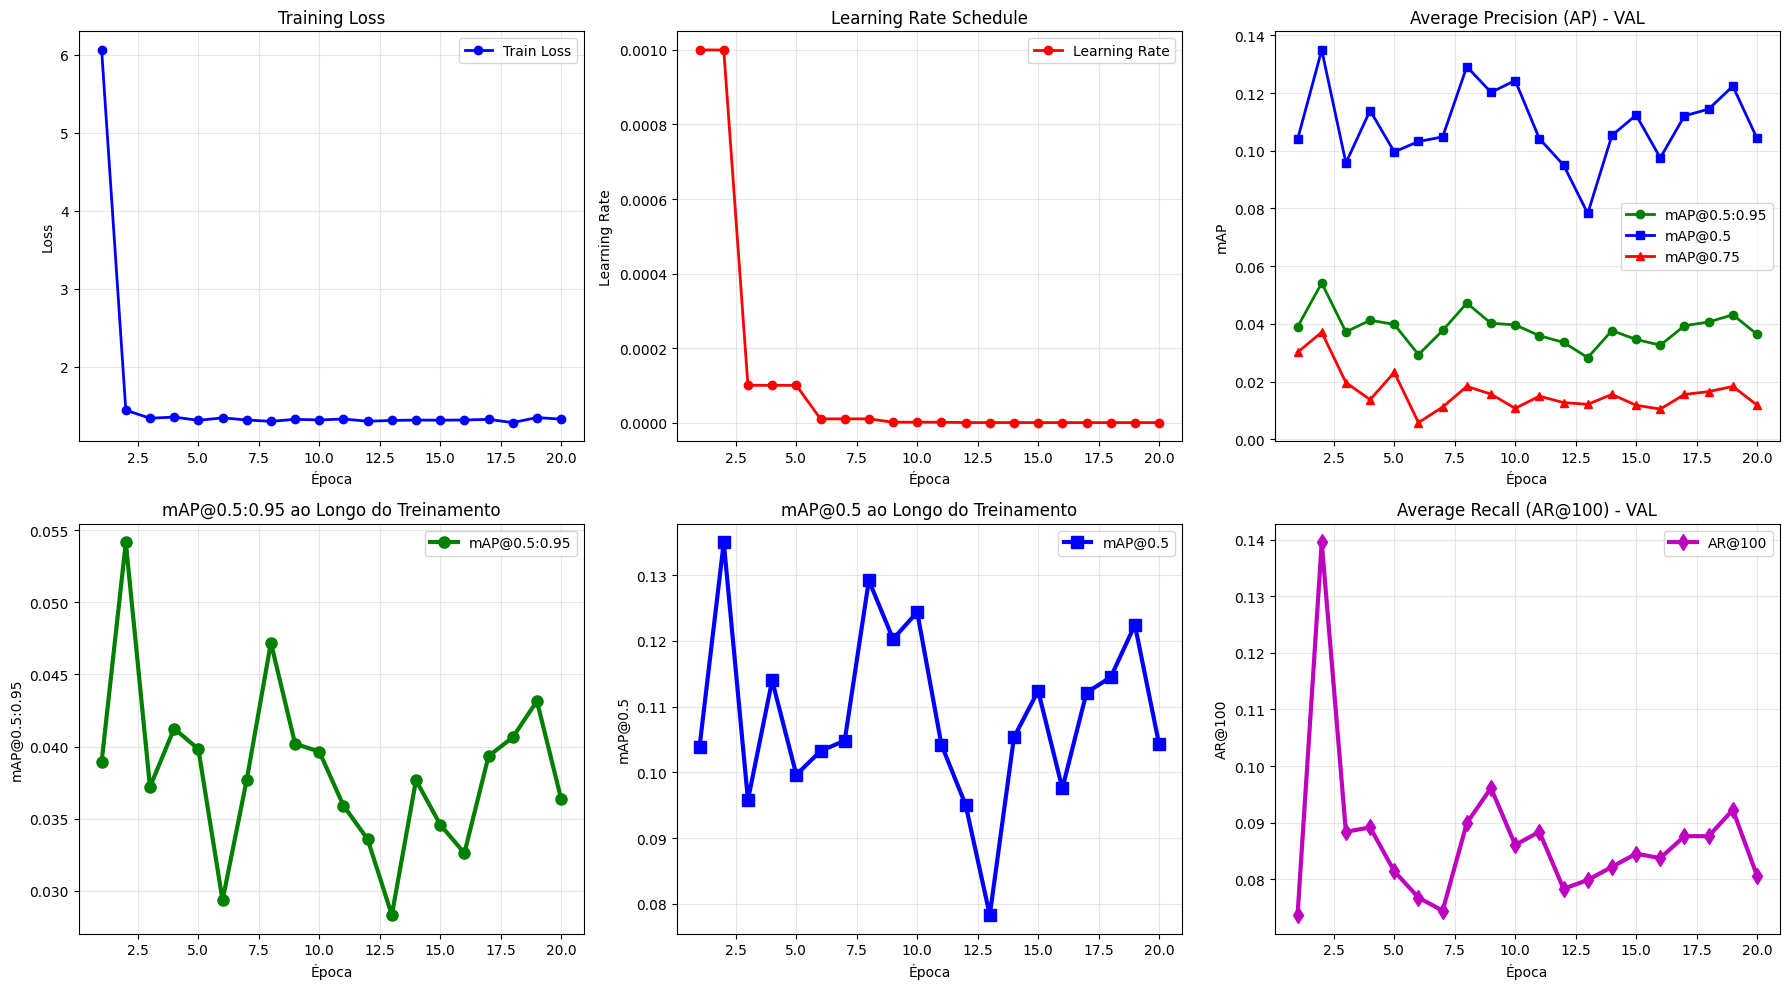

✅ Gráficos salvos em: runs/aula9_coco_gun\training_history.png


In [16]:
# ================================================================
# VISUALIZAR HISTÓRICO DE TREINAMENTO
# ================================================================

if os.path.exists(os.path.join(save_dir, "history.json")):
    with open(os.path.join(save_dir, "history.json"), 'r') as f:
        history = json.load(f)
    
        # Criar figura com múltiplos subplots
    fig = plt.figure(figsize=(18, 10))
    
    # Plot 1: Loss
    plt.subplot(2, 3, 1)
    plt.plot(history["epoch"], history["train_loss"], 'b-', linewidth=2, label='Train Loss', marker='o')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Learning Rate
    plt.subplot(2, 3, 2)
    plt.plot(history["epoch"], history["lr"], 'r-', linewidth=2, label='Learning Rate', marker='o')
    plt.xlabel('Época')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 3: mAP principais
    plt.subplot(2, 3, 3)
    plt.plot(history["epoch"], history["map50_95"], 'g-', linewidth=2, label='mAP@0.5:0.95', marker='o')
    plt.plot(history["epoch"], history["map50"], 'b-', linewidth=2, label='mAP@0.5', marker='s')
    plt.plot(history["epoch"], history["map75"], 'r-', linewidth=2, label='mAP@0.75', marker='^')
    plt.xlabel('Época')
    plt.ylabel('mAP')
    plt.title('Average Precision (AP) - VAL')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 4: mAP@0.5:0.95 (principal)
    plt.subplot(2, 3, 4)
    plt.plot(history["epoch"], history["map50_95"], 'g-', linewidth=3, label='mAP@0.5:0.95', marker='o', markersize=8)
    plt.xlabel('Época')
    plt.ylabel('mAP@0.5:0.95')
    plt.title('mAP@0.5:0.95 ao Longo do Treinamento')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 5: mAP@0.5
    plt.subplot(2, 3, 5)
    plt.plot(history["epoch"], history["map50"], 'b-', linewidth=3, label='mAP@0.5', marker='s', markersize=8)
    plt.xlabel('Época')
    plt.ylabel('mAP@0.5')
    plt.title('mAP@0.5 ao Longo do Treinamento')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 6: AR@100
    plt.subplot(2, 3, 6)
    plt.plot(history["epoch"], history["ar_all_100"], 'm-', linewidth=3, label='AR@100', marker='d', markersize=8)
    plt.xlabel('Época')
    plt.ylabel('AR@100')
    plt.title('Average Recall (AR@100) - VAL')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_history.png"), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Gráficos salvos em: {os.path.join(save_dir, 'training_history.png')}")
else:
    print("⚠️  Histórico não encontrado. Execute o treinamento primeiro.")


In [17]:
# ================================================================
# CÓDIGO MODIFICADO PARA O LOOP DE TREINAMENTO
# ================================================================
# SUBSTITUA O HISTÓRICO E O LOOP DE TREINAMENTO NA CÉLULA 9 POR ESTE CÓDIGO

# Histórico de treinamento (MODIFICADO - adicionar todas as métricas)
history = {
    "epoch": [],
    "train_loss": [],
    "lr": [],
    "map50_95": [],
    "map50": [],
    "map75": [],
    "map50_95_small": [],
    "map50_95_medium": [],
    "map50_95_large": [],
    "ar_all_1": [],
    "ar_all_10": [],
    "ar_all_100": [],
    "ar_small": [],
    "ar_medium": [],
    "ar_large": []
}

# Melhor mAP (usaremos mAP@0.5:0.95 como critério)
best_map = 0.0

print("✅ Histórico modificado para incluir todas as métricas COCO")
print("   📝 Copie este código para substituir o histórico na célula 9")


✅ Histórico modificado para incluir todas as métricas COCO
   📝 Copie este código para substituir o histórico na célula 9


In [18]:
print(f"\n{'='*60}")
print(f"📊 AVALIANDO MODELO NO DATASET DE TESTE {epoch+1}")
print(f"{'='*60}")

model_eval = DetBenchPredict(model.model)
model_eval.eval()
model_eval.to(device)

# Avaliar no dataset de teste
ann_path = os.path.join(root_dir, "coco_annotations_test.json")
metrics = evaluate_coco_completo( 
    model_eval,
    test_dataset,
    ann_path,
    device=device,
    score_threshold=0.3,
    valid_indices=valid_indices
)

print(f"\n📊 MÉTRICAS DA ÉPOCA {epoch+1}:")
print(f"   ✅ mAP@0.5:      {metrics['map50']:.4f} ({metrics['map50']*100:.2f}%)")
print(f"   ✅ mAP@0.5:0.95: {metrics['map50_95']:.4f} ({metrics['map50_95']*100:.2f}%)")
print(f"   ✅ mAP@0.75:     {metrics['map75']:.4f} ({metrics['map75']*100:.2f}%)")
print(f"{'='*60}\n")

# Salvar histórico (ADICIONAR TODAS AS MÉTRICAS)
history["epoch"].append(epoch + 1)
history["train_loss"].append(avg_loss)
history["lr"].append(current_lr)
history["map50_95"].append(metrics['map50_95'])
history["map50"].append(metrics['map50'])
history["map75"].append(metrics['map75'])
history["map50_95_small"].append(metrics['map50_95_small'])
history["map50_95_medium"].append(metrics['map50_95_medium'])
history["map50_95_large"].append(metrics['map50_95_large'])
history["ar_all_1"].append(metrics['ar_all_1'])
history["ar_all_10"].append(metrics['ar_all_10'])
history["ar_all_100"].append(metrics['ar_all_100'])
history["ar_small"].append(metrics['ar_small'])
history["ar_medium"].append(metrics['ar_medium'])
history["ar_large"].append(metrics['ar_large'])

# Salvar melhor modelo (baseado em mAP@0.5:0.95)
current_map = metrics['map50_95']
if current_map > best_map:
    best_map = current_map
    model_path = os.path.join(save_dir, "best_model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"\n   💾 Melhor modelo salvo! (mAP@0.5:0.95: {best_map:.4f})")
    print(f"      📂 Caminho: {model_path}")

print("✅ Código de avaliação durante treinamento criado!")
print("   📝 Adicione este código no loop de treinamento (célula 9) após atualizar o learning rate")



📊 AVALIANDO MODELO NO DATASET DE TESTE 20

🔍 INÍCIO DA AVALIAÇÃO COCO
📂 Anotações: dataset_final_coco\coco_annotations_test.json
🎯 Score threshold: 0.3
💻 Device: cuda
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
⚠️  Adicionando chave 'info' ao dataset COCO
📊 Categoria detectada no COCO: [1]
📋 category_id usado para predições: 1

🔄 Processando 100 imagens...

🔍 DEBUG - Primeira imagem (image_id=1):
   Total de predições antes do filtro: 100
   Scores: min=0.049, max=0.245, mean=0.076
   Labels únicos: [1]
   Predições após filtro (score>=0.3): 0
⏳ Processadas 10/100 imagens...
⏳ Processadas 20/100 imagens...
⏳ Processadas 30/100 imagens...
⏳ Processadas 40/100 imagens...
⏳ Processadas 50/100 imagens...
⏳ Processadas 60/100 imagens...
⏳ Processadas 70/100 imagens...
⏳ Processadas 80/100 imagens...
⏳ Processadas 90/100 imagens...
⏳ Processadas 100/100 imagens...

✅ Processamento concluído!
📸 Imagens avaliadas: 100
📊 Predições válidas: 42

🔍 DEBUG - P


🎨 VISUALIZANDO PREDIÇÕES DO MODELO
   📸 Número de imagens: 6
   🎯 Score threshold: 0.3
   💻 Device: cuda

💾 Imagem EfficientDet salva em: comparacoes_modelos/visualizacoes\efficientdet_predictions.png


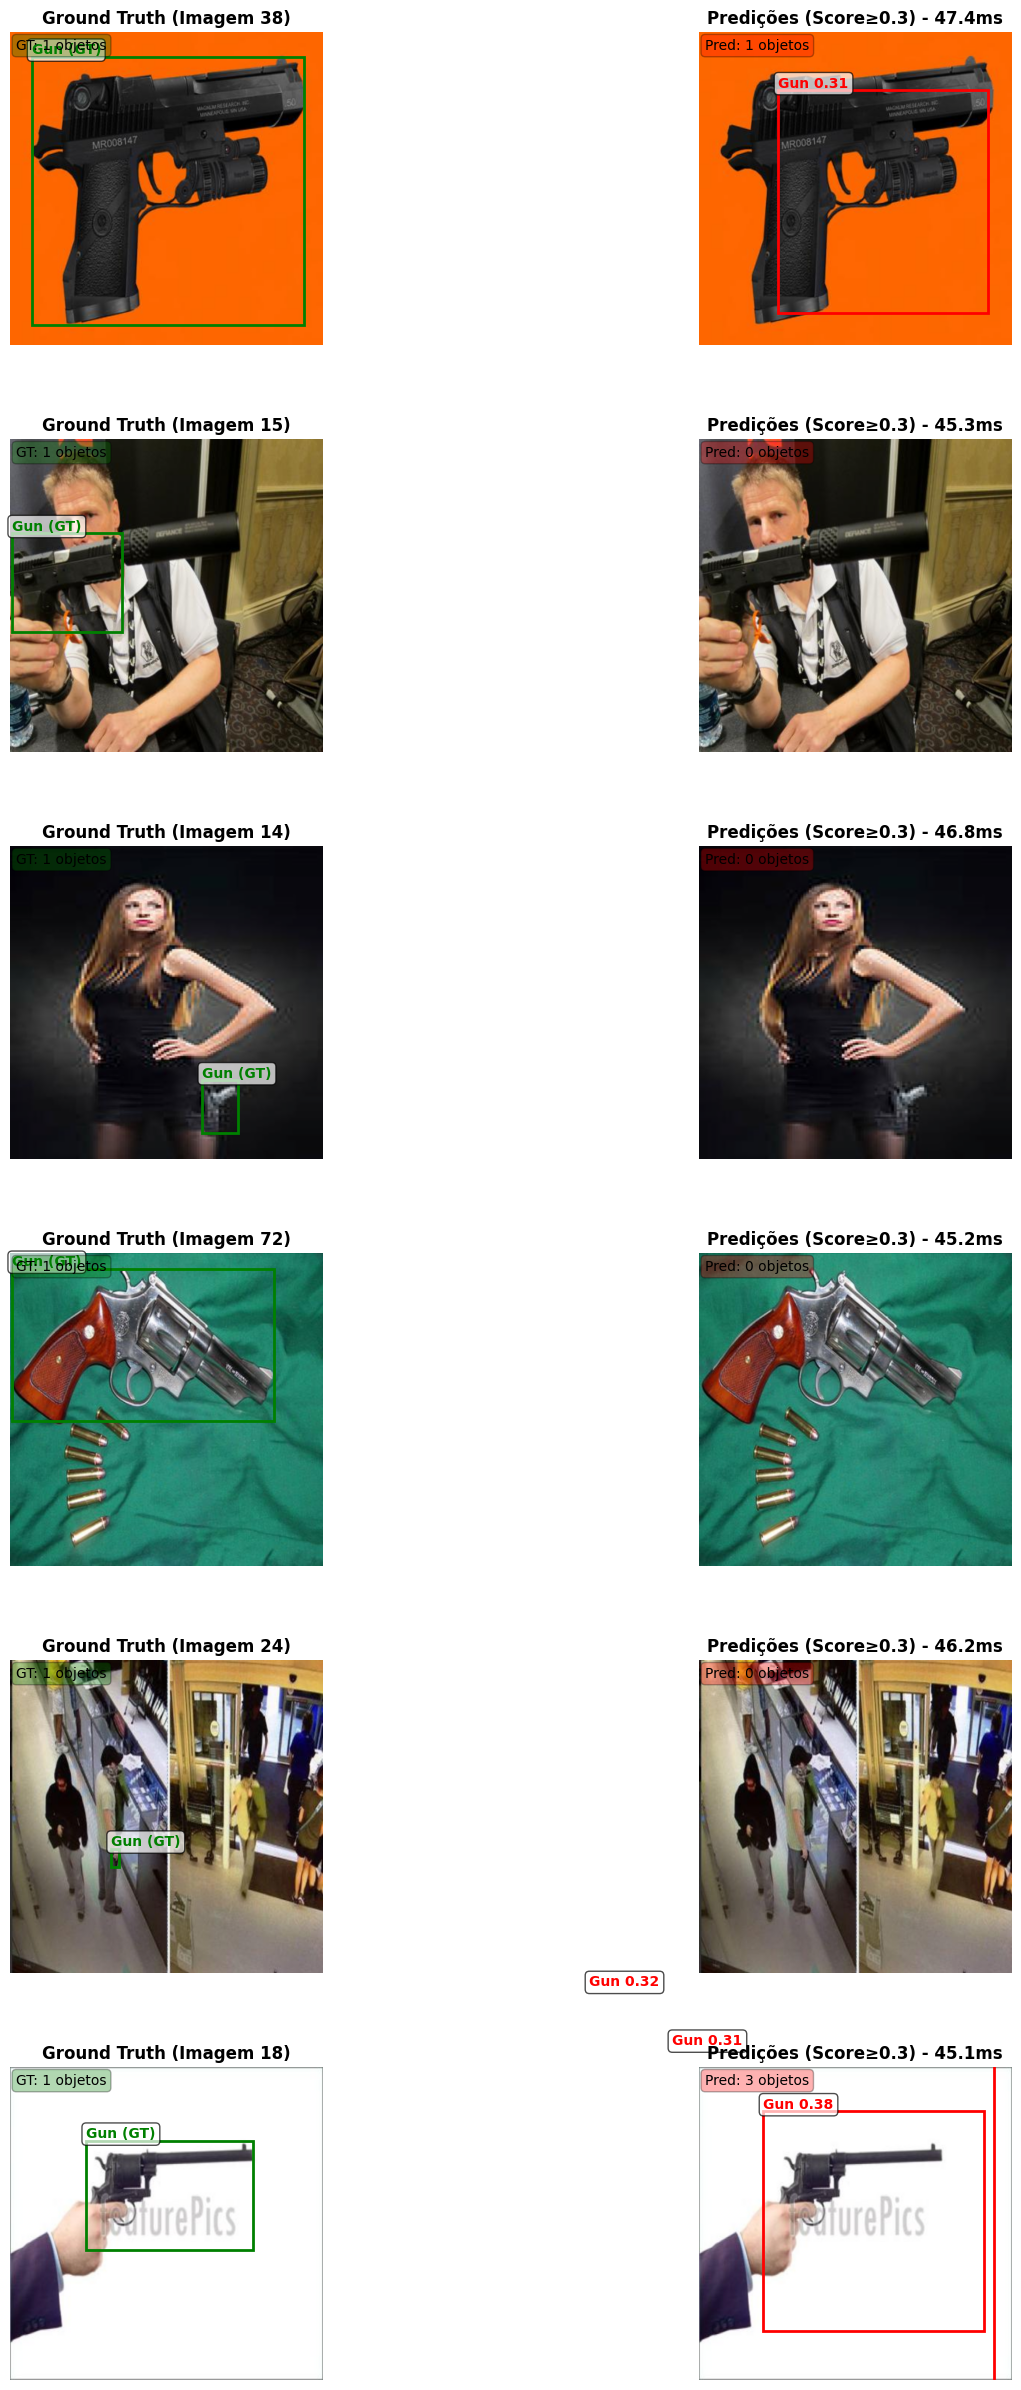


⏱️  ESTATÍSTICAS DE TEMPO DE INFERÊNCIA
   📊 Número de imagens testadas: 6
   ⏱️  Tempo médio: 46.00 ms
   📈 Desvio padrão: 0.86 ms
   ⬇️  Tempo mínimo: 45.08 ms
   ⬆️  Tempo máximo: 47.38 ms
   🚀 FPS médio: 21.74 frames/segundo



In [19]:
# ================================================================
# VISUALIZAÇÃO DE PREDIÇÕES E CÁLCULO DE TEMPO DE INFERÊNCIA
# ================================================================

import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Desnormaliza imagem tensor para visualização"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

def visualize_predictions(model, dataset, device, num_images=6, score_threshold=0.3):
    model.eval()
    
    valid_indices = [i for i in range(len(dataset)) if dataset[i] is not None]
    selected_indices = np.random.choice(valid_indices, min(num_images, len(valid_indices)), replace=False)
    
    inference_times = []
    
    fig, axes = plt.subplots(num_images, 2, figsize=(16, 4*num_images))
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sample_idx in enumerate(selected_indices):
        image_tensor, target = dataset[sample_idx]
        
        image_np = denormalize_image(image_tensor).permute(1, 2, 0).cpu().numpy()
        image_np = np.clip(image_np, 0, 1)

        gt_boxes = target['boxes'].float().cpu().numpy()
        gt_labels = target['labels'].cpu().numpy()
        
        image_batch = image_tensor.unsqueeze(0).to(device)
        
        start_time = time.time()
        with torch.no_grad():
            predictions = model(image_batch)[0]   # continua igual
        inference_time = time.time() - start_time
        inference_times.append(inference_time)

        preds = predictions[0] if isinstance(predictions, list) else predictions
        
        pred_boxes  = preds[:, 0:4].float().cpu().numpy()
        pred_scores = preds[:, 4].float().cpu().numpy()
        pred_labels = preds[:, 5].cpu().numpy().astype(int)
        
        # Aplicar filtro de score
        mask = pred_scores >= score_threshold
        pred_boxes = pred_boxes[mask]
        pred_scores = pred_scores[mask]
        pred_labels = pred_labels[mask]
        
        # Plot Ground Truth (esquerda)
        ax_gt = axes[idx, 0]
        ax_gt.imshow(image_np)
        ax_gt.set_title(f'Ground Truth (Imagem {sample_idx})', fontsize=12, fontweight='bold')
        ax_gt.axis('off')
        
        # Desenhar caixas do ground truth (verde)
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='green', facecolor='none'
            )
            ax_gt.add_patch(rect)
            ax_gt.text(x1, y1-5, 'Gun (GT)', color='green', fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        # Plot Predições (direita)
        ax_pred = axes[idx, 1]
        ax_pred.imshow(image_np)
        ax_pred.set_title(f'Predições (Score≥{score_threshold}) - {inference_time*1000:.1f}ms', 
                          fontsize=12, fontweight='bold')
        ax_pred.axis('off')
        
        # Desenhar caixas das predições (vermelho)
        for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax_pred.add_patch(rect)
            ax_pred.text(x1, y1-5, f'Gun {score:.2f}', color='red', fontsize=10, fontweight='bold',
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        # Adicionar contadores
        ax_gt.text(0.02, 0.98, f'GT: {len(gt_boxes)} objetos', 
                   transform=ax_gt.transAxes, fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
        ax_pred.text(0.02, 0.98, f'Pred: {len(pred_boxes)} objetos', 
                     transform=ax_pred.transAxes, fontsize=10, verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
    
    plt.tight_layout()
    
    # Salvar imagem
    output_dir = "comparacoes_modelos/visualizacoes"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, "efficientdet_predictions.png"), dpi=300, bbox_inches='tight')
    print(f"💾 Imagem EfficientDet salva em: {os.path.join(output_dir, 'efficientdet_predictions.png')}")
    
    plt.show()
    
    # Calcular estatísticas de tempo
    avg_time = np.mean(inference_times)
    std_time = np.std(inference_times)
    min_time = np.min(inference_times)
    max_time = np.max(inference_times)
    
    print(f"\n{'='*60}")
    print(f"⏱️  ESTATÍSTICAS DE TEMPO DE INFERÊNCIA")
    print(f"{'='*60}")
    print(f"   📊 Número de imagens testadas: {len(inference_times)}")
    print(f"   ⏱️  Tempo médio: {avg_time*1000:.2f} ms")
    print(f"   📈 Desvio padrão: {std_time*1000:.2f} ms")
    print(f"   ⬇️  Tempo mínimo: {min_time*1000:.2f} ms")
    print(f"   ⬆️  Tempo máximo: {max_time*1000:.2f} ms")
    print(f"   🚀 FPS médio: {1/avg_time:.2f} frames/segundo")
    print(f"{'='*60}\n")
    
    return inference_times

# Carregar melhor modelo se ainda não estiver carregado
if 'model' not in locals() or model is None:
    print("📂 Carregando melhor modelo...")
    # Verificar se save_dir está definida
    if 'save_dir' in locals():
        model_path = os.path.join(save_dir, "best_model.pth")
    else:
        # Tentar caminho padrão
        model_path = "runs/aula9_coco_gun/best_model.pth"
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
        print(f"✅ Modelo carregado de: {model_path}")
    else:
        print(f"⚠️  Modelo não encontrado em: {model_path}")
        print("   Usando modelo atual (se disponível)")

# Garantir que o modelo está no device correto
model = model.to(device)
model.eval()

print(f"\n{'='*60}")
print(f"🎨 VISUALIZANDO PREDIÇÕES DO MODELO")
print(f"{'='*60}")
print(f"   📸 Número de imagens: 6")
print(f"   🎯 Score threshold: 0.3")
print(f"   💻 Device: {device}")
print(f"{'='*60}\n")

model_eval = DetBenchPredict(model.model)
model_eval.eval()
model_eval.to(device)

# Visualizar predições
inference_times = visualize_predictions(
    model=model_eval,
    dataset=test_dataset,
    device=device,
    num_images=6,
    score_threshold=0.3
)
